# importとか定数とか

In [1]:
import warnings
warnings.filterwarnings('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
RANDOM_STATE = 0
CV=5

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture as GMM


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.datasets import load_boston

# データ取得と内容確認

In [2]:
data = load_boston()

In [3]:
df = pd.DataFrame(data["data"], columns=data["feature_names"])
df["target"] = data["target"]

In [4]:
df.head()

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  target  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2

In [5]:
df.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT      target  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

# 可視化ごっこ

### 目的変数のhist

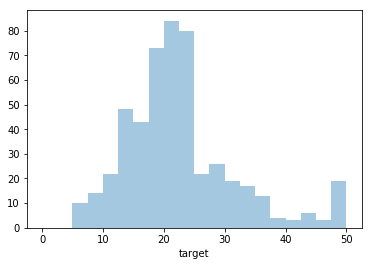

In [6]:
sns.distplot(df["target"], bins=20, kde=False, hist_kws={"range": [0,50]})
plt.show()
plt.close()

### scatterのmatrix（正式名称なんだっけ？）

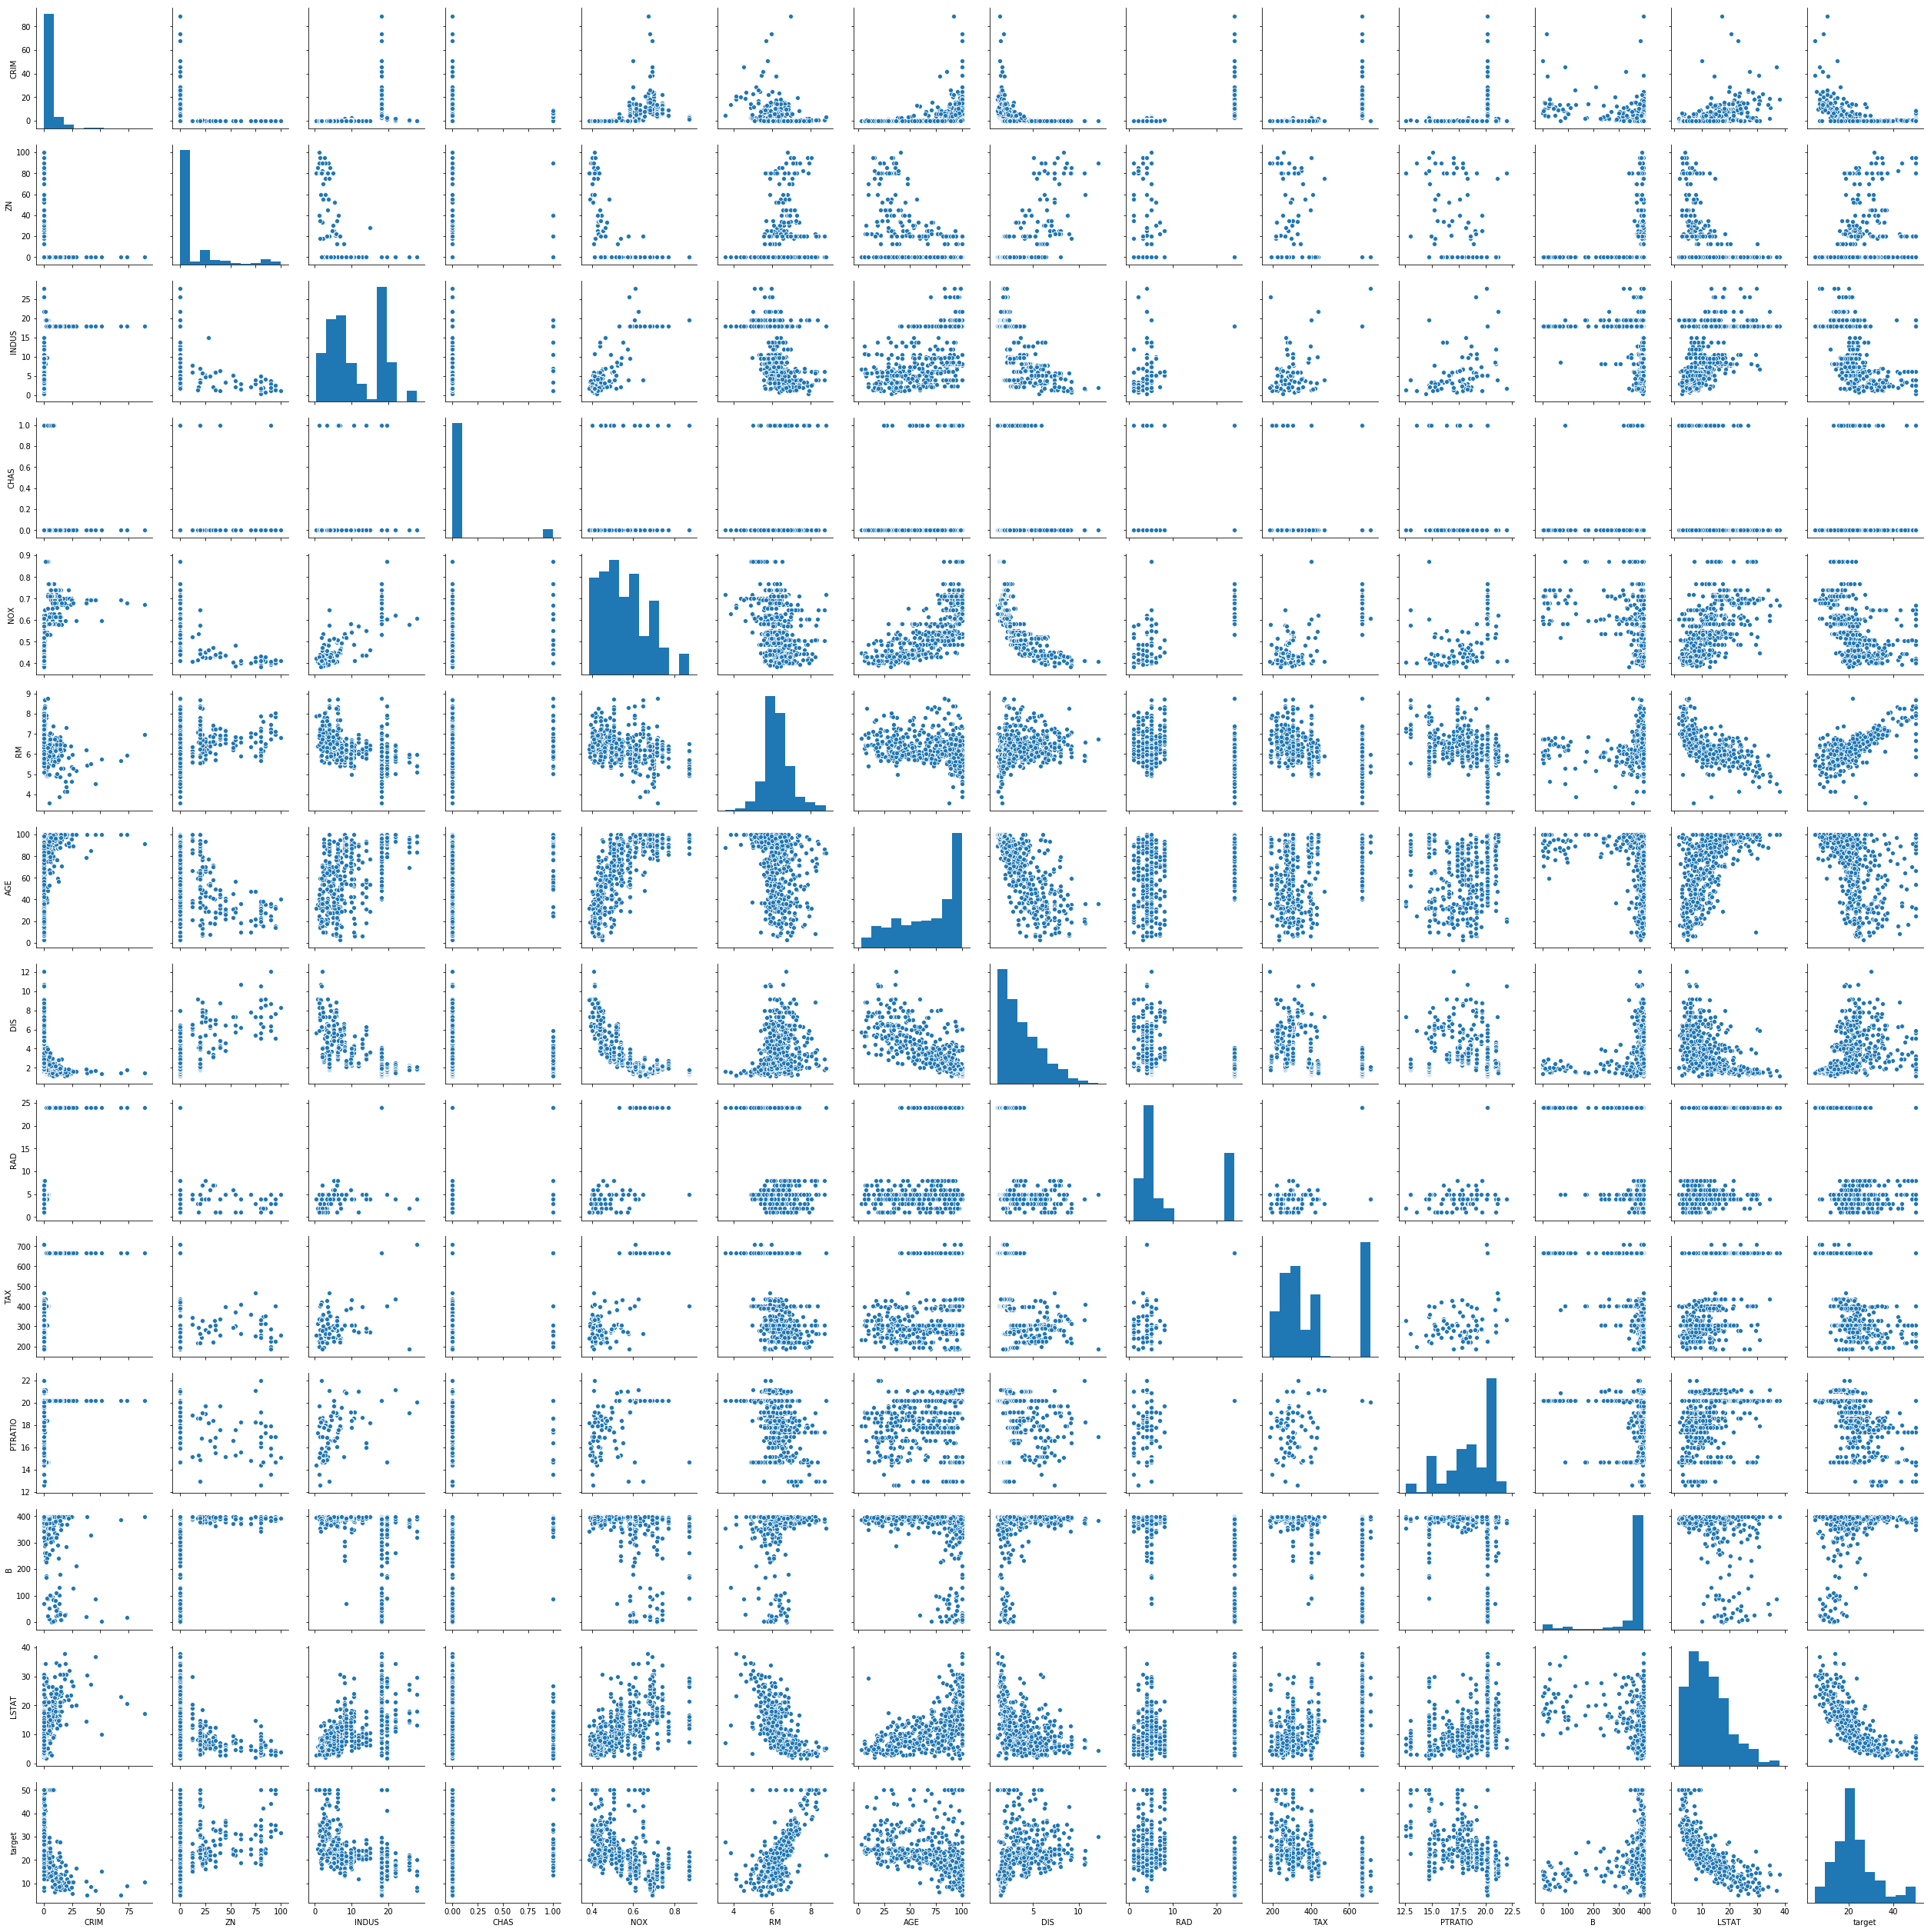

In [7]:
sns.pairplot(df)
plt.show()
plt.close()

### 相関係数の確認

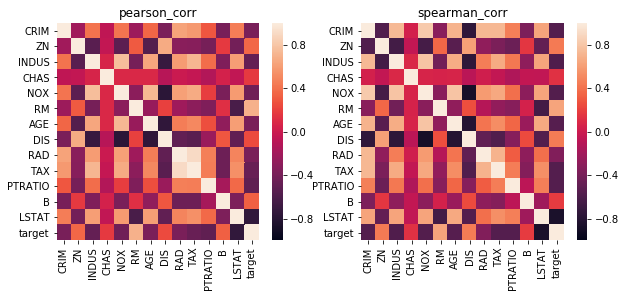

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(df.corr(method="pearson"), vmin=-1.0, vmax=1.0)
plt.title("pearson_corr")

plt.subplot(1, 2, 2)
sns.heatmap(df.corr(method="spearman"), vmin=-1.0, vmax=1.0)
plt.title("spearman_corr")

plt.show()
plt.close()

# モデリングごっこ（次元削減）

In [9]:
X_cols =[c for c in df.columns if c != "target"]
y_col = "target"
X = df[X_cols]
y = df[y_col] # あとで教師あり学習したいからyも用意しておく

### とりあえず標準化

In [10]:
sc = StandardScaler()
sc.fit(X)
X_sc = sc.transform(X)

### PCA

In [11]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca.fit(X_sc)
X_pca = pca.transform(X_sc)

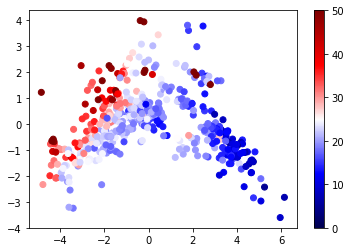

In [12]:
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], vmin=0, vmax=50, c=y, cmap=cm.seismic)
plt.colorbar(scatter)
plt.show()
plt.close()

### tSNE

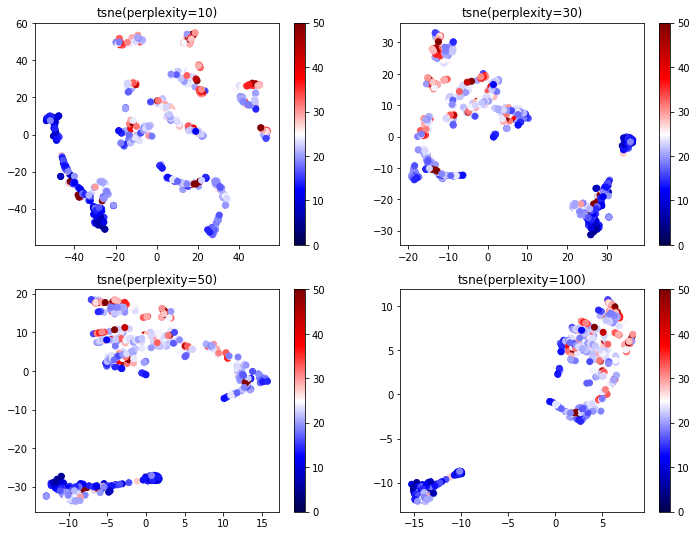

In [13]:
plt.figure(figsize=(12, 9))
for i, perplexity in enumerate([10, 30, 50, 100]):
    plt.subplot(2, 2, i+1)
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, random_state=RANDOM_STATE)
    X_tsne = tsne.fit_transform(X)
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], vmin=0, vmax=50, c=y, cmap=cm.seismic)
    plt.colorbar(scatter)
    plt.title("tsne(perplexity=%d)" % (perplexity))
plt.show()
plt.close()

# モデリングごっこ（教師あり学習）

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [15]:
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)

In [16]:
def train_and_eval(reg, X_train, X_test, y_train, y_test):
    reg.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    score_tr = reg.score(X_train, y_train)
    print("R2_score:", score)
    print("R2_score_tr:", score_tr)

### ふつーに線形回帰

In [17]:
reg = LinearRegression()
train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)

R2_score: 0.6733825506400196
R2_score_tr: 0.7645451026942549


### Ridge

In [18]:
for alpha in [0.1, 1.0, 10]:
    print("alpha: ", alpha)
    reg = Ridge(alpha=alpha)
    train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)
    print()

alpha:  0.1
R2_score: 0.6733217490061539
R2_score_tr: 0.764544899172055

alpha:  1.0
R2_score: 0.6727737684528233
R2_score_tr: 0.7645258699709746

alpha:  10
R2_score: 0.6674648670481824
R2_score_tr: 0.7633167147255946



### Lasso

In [19]:
for alpha in [0.1, 1.0, 10]:
    print("alpha: ", alpha)
    reg = Lasso(alpha=alpha)
    train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)
    print()

alpha:  0.1
R2_score: 0.6599647116559878
R2_score_tr: 0.759129270664182

alpha:  1.0
R2_score: 0.5999442961470398
R2_score_tr: 0.6927580317165545

alpha:  10
R2_score: -0.0060197319476869016
R2_score_tr: 0.0



### ElasticNet

In [20]:
for alpha in [0.1, 1.0, 10]:
    print("alpha: ", alpha)
    reg = ElasticNet(alpha=alpha)
    train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)
    print()

alpha:  0.1
R2_score: 0.6578341991139103
R2_score_tr: 0.7585761618852822

alpha:  1.0
R2_score: 0.5810435065985062
R2_score_tr: 0.6782894824529212

alpha:  10
R2_score: 0.0712171543315735
R2_score_tr: 0.07804191307559749



### RandomForest

##### チューニングなし

In [21]:
reg = RandomForestRegressor(random_state=RANDOM_STATE)
train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)

R2_score: 0.7537781223565037
R2_score_tr: 0.9732125069724568


##### チューニングあり

In [22]:
parameters = {
    "n_estimators": [5, 10, 20], 
    "max_depth": [4, 8, 16], 
}
reg = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), parameters, cv=CV)
train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)

R2_score: 0.8011737825165223
R2_score_tr: 0.9727798216076544


c:\users\jinba\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### SVM

##### チューニングなし

In [23]:
reg = SVR()
train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)

R2_score: 0.554345403735911
R2_score_tr: 0.6979834985580842


##### チューニングあり

In [24]:
parameters = {
    "C": [0.1, 1.0, 10], 
    "gamma": [0.1, 1.0, 10], 
}
reg = GridSearchCV(SVR(), parameters, cv=CV)
train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)

R2_score: 0.7341126826225308
R2_score_tr: 0.9181634639369695


c:\users\jinba\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### GradientBoost

##### チューニングなし

In [25]:
reg = GradientBoostingRegressor(random_state=RANDOM_STATE)
train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)

R2_score: 0.8404660974448279
R2_score_tr: 0.985130906801384


##### チューニングあり(GridSearchCV)

In [26]:
parameters = {
    "n_estimators": [50, 100, 200], 
    "max_depth": [3, 6, 12], 
    "learning_rate": [0.05, 0.1, 0.2], 
}
reg = GridSearchCV(GradientBoostingRegressor(random_state=RANDOM_STATE), parameters, cv=CV)
train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)

R2_score: 0.844342420503446
R2_score_tr: 0.9990829388330529


c:\users\jinba\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


##### チューニングあり(hyperopt)

In [27]:
def objective(params):
#     params = {
#         'max_depth': int(params['max_depth']),
#         'gamma': "{:.3f}".format(params['gamma']),
#         'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
#     }
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']), 
        "learning_rate": params["learning_rate"], 
    }
    
    reg = GradientBoostingRegressor(
        random_state=RANDOM_STATE, **params
    )
    score = cross_val_score(reg, X_train_sc, y_train, scoring="r2", cv=5).mean()
    return -score

In [28]:
space = {
    'n_estimators': 50 * 2 ** hp.quniform('n_estimators', 0, 2, 1),
    'max_depth': 3 * 2 ** hp.quniform('max_depth', 0, 2, 1),
    "learning_rate": 0.05 * 2 ** hp.quniform('learning_rate', 0, 2, 1),
}
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

In [29]:
reg = GradientBoostingRegressor(
    random_state=RANDOM_STATE, 
    n_estimators=int(50 * 2 ** best['n_estimators']),
    max_depth=int(3 * 2 ** best['max_depth']),
    learning_rate=0.05 * 2 ** best["learning_rate"],
)
train_and_eval(reg, X_train_sc, X_test_sc, y_train, y_test)

R2_score: 0.8250465010438853
R2_score_tr: 0.971204775873813


### 予測結果を可視化

In [30]:
parameters = {
    "n_estimators": [50, 100, 200], 
    "max_depth": [3, 6, 12], 
#     "learning_rate": [0.05, 0.1, 0.5], # 20181124　これがベスト
    "learning_rate": [0.05, 0.1, 0.2], 
}
reg = GridSearchCV(GradientBoostingRegressor(random_state=RANDOM_STATE), parameters, cv=CV)
reg.fit(X_train_sc, y_train)
pred = reg.predict(X_test_sc)

c:\users\jinba\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


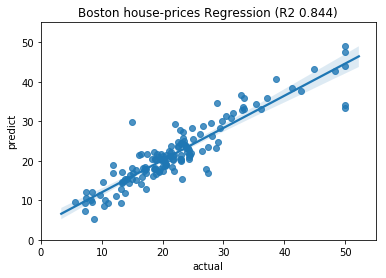

In [31]:
xlim = [0, 55]
ylim = [0, 55]
sns.regplot(y_test, pred)
plt.xlabel("actual")
plt.ylabel("predict")
plt.title("Boston house-prices Regression (R2 %1.3f)" % (r2_score(y_test, pred)))
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()
plt.close()

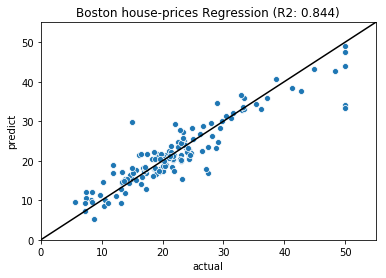

In [32]:
xlim = [0, 55]
ylim = [0, 55]
sns.lineplot(xlim, ylim, color="black")
sns.scatterplot(y_test, pred)
plt.xlabel("actual")
plt.ylabel("predict")
plt.title("Boston house-prices Regression (R2: %1.3f)" % (r2_score(y_test, pred)))
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()
plt.close()

# モデリングごっこ（クラスタリング）

In [33]:
# tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, random_state=RANDOM_STATE)
# X_train_tsne = tsne.fit_transform(X_train_sc)
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_sc)

### kmeans

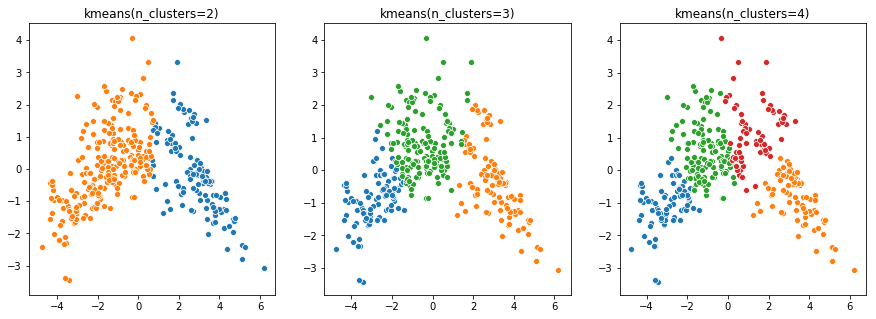

In [34]:
plt.figure(figsize=(15, 5))
for i, n_clusters in enumerate([2, 3, 4]):
    plt.subplot(1, 3, i+1)
    kmeans = KMeans(n_clusters=n_clusters).fit(X_train_pca)
    for label in set(kmeans.labels_):
        ind = kmeans.labels_ == label
        X_label = X_train_pca[ind, :]
        sns.scatterplot(X_label[:, 0], X_label[:, 1])
    plt.title("kmeans(n_clusters=%d)" % (n_clusters))
plt.show()
plt.close()

### DBSCAN

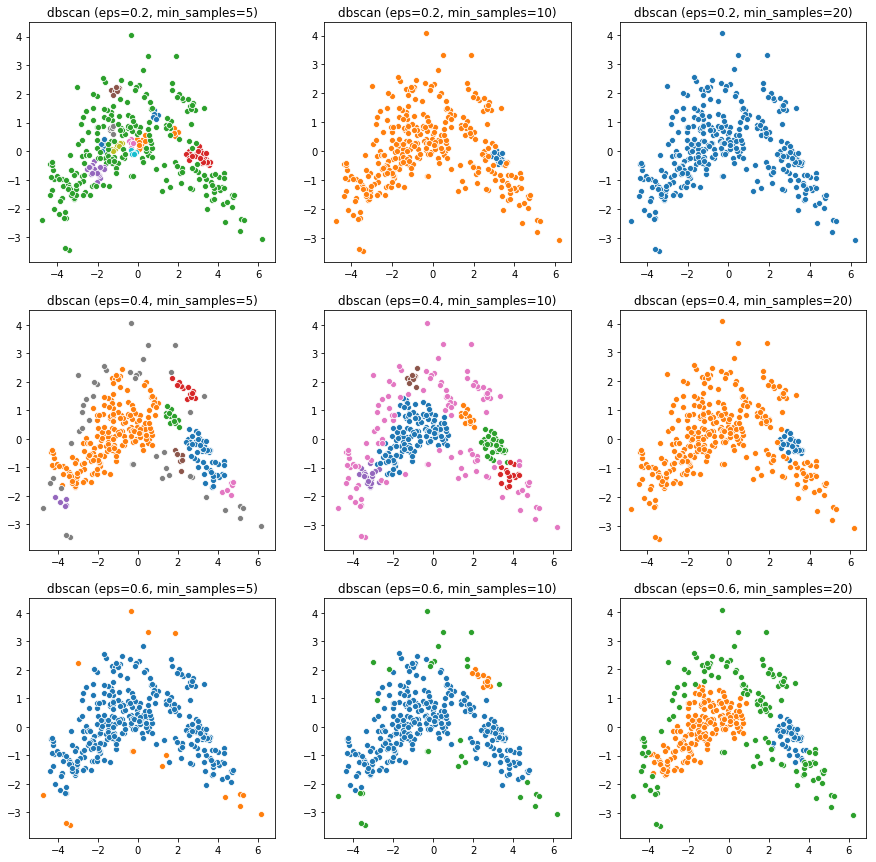

In [35]:
plt.figure(figsize=(15, 15))
n = 1
for eps in [0.2, 0.4, 0.6]:
    for min_samples in [5, 10, 20]:
        plt.subplot(3, 3, n)
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_train_pca)
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_train_tsne)
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(X_train_sc)
        for label in set(dbscan.labels_):
            ind = dbscan.labels_ == label
            X_label = X_train_pca[ind, :]
            sns.scatterplot(X_label[:, 0], X_label[:, 1])
        plt.title("dbscan (eps=%1.1f, min_samples=%d)" % (eps, min_samples))
        n += 1
plt.show()
plt.close()

### GMM

##### ハード

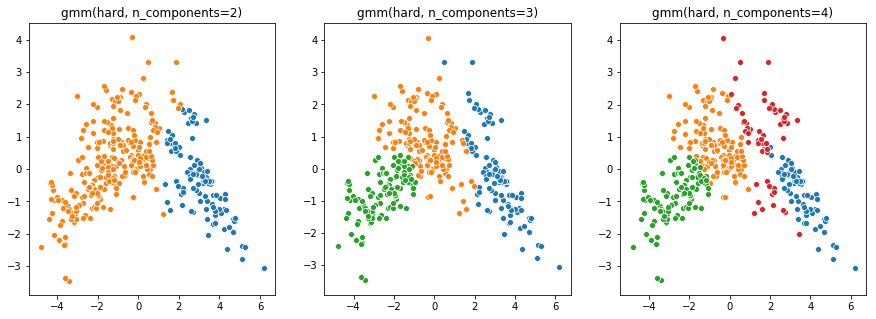

In [36]:
plt.figure(figsize=(15, 5))
for i, n_components in enumerate([2, 3, 4]):
    plt.subplot(1, 3, i+1)
    gmm = GMM(n_components=n_components, max_iter=1000, random_state=RANDOM_STATE).fit(X_train_pca)
    gmm_labels_ = gmm.predict(X_train_pca)
    for label in set(gmm_labels_):
        ind = gmm_labels_ == label
        X_label = X_train_pca[ind, :]
        sns.scatterplot(X_label[:, 0], X_label[:, 1])
    plt.title("gmm(hard, n_components=%d)" % (n_components))
plt.show()
plt.close()

##### ソフト

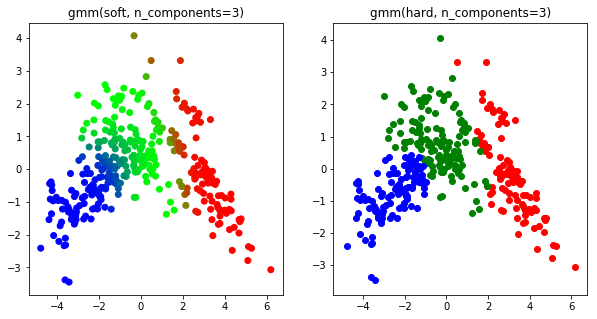

In [37]:
n_components = 3
plt.figure(figsize=(10, 5))

# ソフト
plt.subplot(1, 2, 1)
gmm = GMM(n_components=n_components, max_iter=1000, random_state=RANDOM_STATE).fit(X_train_pca)
gmm_prob = gmm.predict_proba(X_train_pca)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], color=[(_p[0], _p[1], _p[2]) for _p in gmm_prob])
plt.title("gmm(soft, n_components=%d)" % (n_components))

# ハードと比較
plt.subplot(1, 2, 2)
gmm = GMM(n_components=n_components, max_iter=1000, random_state=RANDOM_STATE).fit(X_train_pca)
gmm_labels_ = gmm.predict(X_train_pca)
for label, color in zip(set(gmm_labels_), ["r", "g", "b"]):
    ind = gmm_labels_ == label
    X_label = X_train_pca[ind, :]
    plt.scatter(X_label[:, 0], X_label[:, 1], color=color)
plt.title("gmm(hard, n_components=%d)" % (n_components))

plt.show()
plt.close()